In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
casualty_data = pd.read_csv('dft-road-casualty-statistics-casualty-2023.csv', low_memory=False)
collision_data = pd.read_csv('dft-road-casualty-statistics-collision-2023.csv', low_memory=False)
vehicle_data = pd.read_csv('dft-road-casualty-statistics-vehicle-2023.csv', low_memory=False)

# 合并数据（以 accident_index 为主键）
data = pd.merge(collision_data, vehicle_data, on='accident_index', how='inner')
data = pd.merge(data, casualty_data, on='accident_index', how='inner')

# 筛选时间范围（2021-2023 年）
data = data[(data['accident_year'] >= 2021) & (data['accident_year'] <= 2023)]

# 检查数据结构
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252899 entries, 0 to 252898
Data columns (total 90 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               252899 non-null  object 
 1   accident_year_x                              252899 non-null  int64  
 2   accident_reference_x                         252899 non-null  object 
 3   location_easting_osgr                        252875 non-null  float64
 4   location_northing_osgr                       252875 non-null  float64
 5   longitude                                    252875 non-null  float64
 6   latitude                                     252875 non-null  float64
 7   police_force                                 252899 non-null  int64  
 8   accident_severity                            252899 non-null  int64  
 9   number_of_vehicles                           252899 non-nul

In [95]:
# 删除缺失率较高的列
data = data.drop(columns=['dir_from_e', 'dir_from_n', 'dir_to_e', 'dir_to_n'])

# 删除含有少量缺失值的行（以地理位置字段为例）
data = data.dropna(subset=['location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude'])

# 将分类字段转换为类别类型
categorical_columns = ['sex_of_driver', 'vehicle_type', 'weather_conditions', 'road_type']
for col in categorical_columns:
    data[col] = data[col].astype('category')

# 筛选关键变量
columns_of_interest = [
    'accident_severity', 'number_of_casualties',
    'age_of_driver', 'sex_of_driver', 'driver_home_area_type', 'driver_imd_decile',
    'vehicle_type', 'age_of_vehicle', 'vehicle_manoeuvre',
    'weather_conditions', 'light_conditions', 'road_surface_conditions',
    'speed_limit', 'urban_or_rural_area'
]
filtered_data = data[columns_of_interest]

# 检查筛选后的数据
print(filtered_data.head())

   accident_severity  number_of_casualties  age_of_driver sex_of_driver  \
0                  3                     1             61             1   
1                  3                     2             54             1   
2                  3                     2             54             1   
3                  3                     2             25             1   
4                  3                     2             25             1   

   driver_home_area_type  driver_imd_decile vehicle_type  age_of_vehicle  \
0                      1                  3           11              13   
1                      1                  6           11               9   
2                      1                  6           11               9   
3                      1                  3            9               1   
4                      1                  3            9               1   

   vehicle_manoeuvre weather_conditions  light_conditions  \
0                  4           

Missing values after cleaning:
accident_index                0
accident_year_x               0
accident_reference_x          0
location_easting_osgr         0
location_northing_osgr        0
                             ..
casualty_home_area_type       0
casualty_imd_decile           0
lsoa_of_casualty              0
enhanced_casualty_severity    0
casualty_distance_banding     0
Length: 86, dtype: int64

Descriptive Statistics:
       accident_year_x  location_easting_osgr  location_northing_osgr  \
count         205641.0          205641.000000            2.056410e+05   
mean            2023.0          452560.169645            2.800351e+05   
std                0.0           94110.252382            1.505289e+05   
min             2023.0           70537.000000            1.052800e+04   
25%             2023.0          390973.000000            1.740830e+05   
50%             2023.0          457327.000000            2.246680e+05   
75%             2023.0          528859.000000           

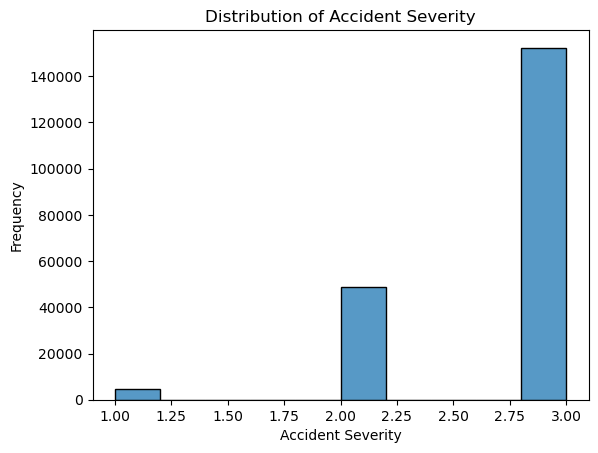

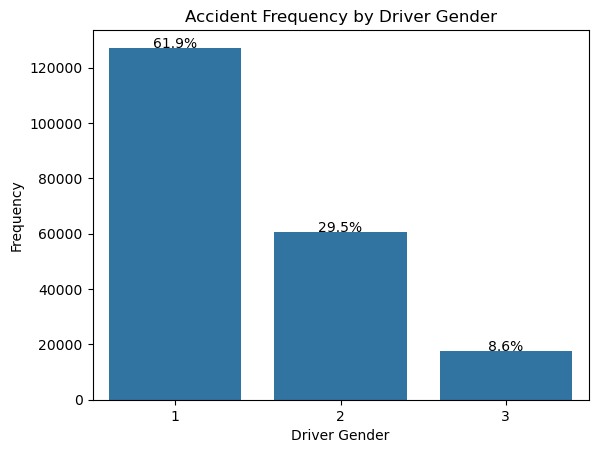

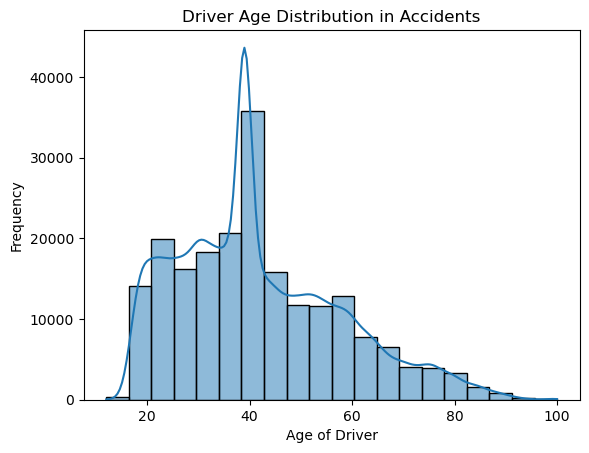

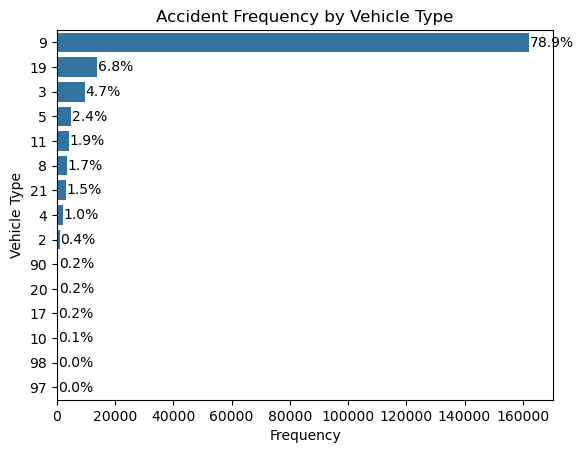

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 替换异常值为 NaN
data['age_of_driver'] = data['age_of_driver'].replace(-1, np.nan)
data['journey_purpose_of_driver'] = data['journey_purpose_of_driver'].replace(-1, np.nan)

# 处理分类变量避免 FutureWarning
data['vehicle_type'] = data['vehicle_type'].astype('object')
data['vehicle_type'] = data['vehicle_type'].replace(-1, np.nan)
data['vehicle_type'] = data['vehicle_type'].astype('category')

data['urban_or_rural_area'] = data['urban_or_rural_area'].replace(-1, np.nan)

# 删除不合理的车辆年龄（假设最大车龄为 50 年）
data = data[data['age_of_vehicle'] <= 50]

# 填补缺失值（中位数或众数）
data['age_of_driver'] = data['age_of_driver'].fillna(data['age_of_driver'].median())
data['journey_purpose_of_driver'] = data['journey_purpose_of_driver'].fillna(data['journey_purpose_of_driver'].mode()[0])
data['vehicle_type'] = data['vehicle_type'].fillna(data['vehicle_type'].mode()[0])
data['urban_or_rural_area'] = data['urban_or_rural_area'].fillna(data['urban_or_rural_area'].mode()[0])

# 检查缺失值
print("Missing values after cleaning:")
print(data.isnull().sum())

# 描述性统计信息
print("\nDescriptive Statistics:")
print(data.describe())

# 可视化：因变量分布 - 事故严重性
sns.histplot(data['accident_severity'], kde=False, bins=10)
plt.title('Distribution of Accident Severity')
plt.xlabel('Accident Severity')
plt.ylabel('Frequency')
plt.show()

# 可视化：性别与事故频率（带比例标注）
ax = sns.countplot(data=data, x='sex_of_driver', order=data['sex_of_driver'].value_counts().index)
total = len(data)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{height/total:.1%}', ha="center")
plt.title('Accident Frequency by Driver Gender')
plt.xlabel('Driver Gender')
plt.ylabel('Frequency')
plt.show()

# 可视化：驾驶员年龄分布
sns.histplot(data=data, x='age_of_driver', bins=20, kde=True)
plt.title('Driver Age Distribution in Accidents')
plt.xlabel('Age of Driver')
plt.ylabel('Frequency')
plt.show()

# 可视化：车辆类型与事故频率
ax = sns.countplot(data=data, y='vehicle_type', order=data['vehicle_type'].value_counts().index)
total = len(data)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 200, p.get_y() + p.get_height() / 2., f'{width/total:.1%}', va="center")
plt.title('Accident Frequency by Vehicle Type')
plt.ylabel('Vehicle Type')
plt.xlabel('Frequency')
plt.show()

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 对分类变量进行编码
categorical_columns = ['sex_of_driver', 'vehicle_type', 'weather_conditions', 
                       'light_conditions', 'road_surface_conditions', 'urban_or_rural_area']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# 特征与目标变量
X = data[['age_of_driver', 'sex_of_driver', 'vehicle_type', 'weather_conditions', 
          'light_conditions', 'road_surface_conditions', 'urban_or_rural_area']]
y = data['accident_severity']

# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Linear Regression Results:
Coefficients: [-0.00152801  0.05210264  0.00409488  0.01413214 -0.03934082 -0.00148337
 -0.12344062]
Intercept: 2.7967607121012845
Mean Squared Error: 0.23826932497567982
R^2 Score: 0.0321626896459285
                   feature       VIF
0            age_of_driver  5.722107
1            sex_of_driver  1.503563
2             vehicle_type  6.399998
3       weather_conditions  1.381696
4         light_conditions  1.322996
5  road_surface_conditions  4.353418
6      urban_or_rural_area  1.742585


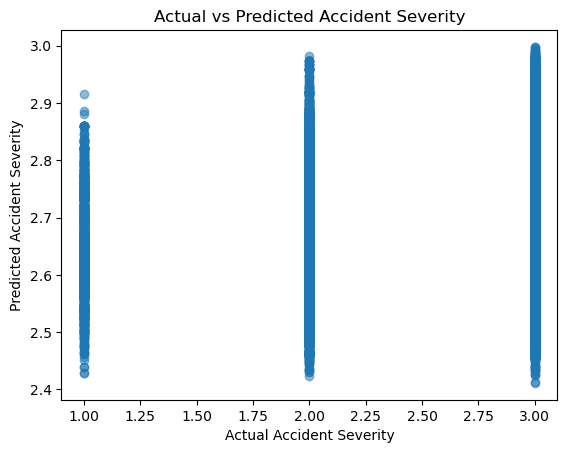

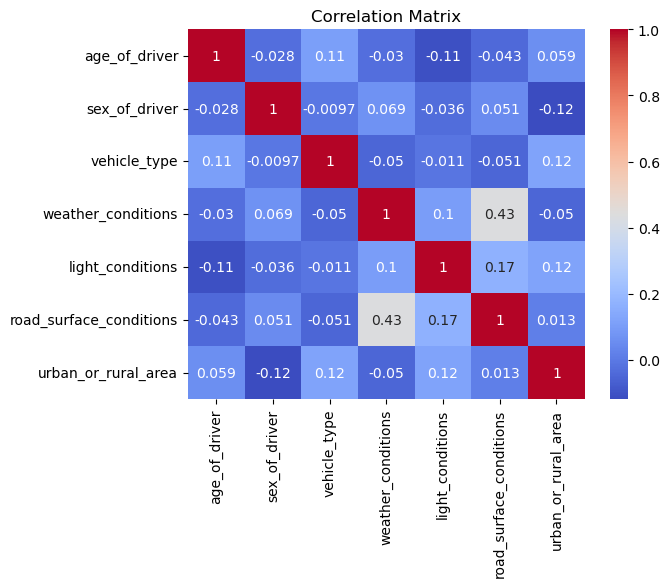

In [111]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 创建线性回归模型
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 预测和评估
y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Results:")
print(f"Coefficients: {lr_model.coef_}")
print(f"Intercept: {lr_model.intercept_}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# 计算 VIF 检测共线性问题
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

# 可视化：实际值 vs 预测值
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs Predicted Accident Severity')
plt.xlabel('Actual Accident Severity')
plt.ylabel('Predicted Accident Severity')
plt.show()

# 可视化相关性矩阵
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

from statsmodels.stats.outliers_influence import variance_inflation_factor


Applying SMOTE to balance classes...
Resampled dataset shape: (394821, 8)
Training Logistic Regression model...
Evaluating model...
Confusion Matrix after SMOTE:
[[ 1048   207   305]
 [ 6486  3666  7585]
 [14025 10155 32393]]

Classification Report after SMOTE:
              precision    recall  f1-score   support

           1       0.05      0.67      0.09      1560
           2       0.26      0.21      0.23     17737
           3       0.80      0.57      0.67     56573

    accuracy                           0.49     75870
   macro avg       0.37      0.48      0.33     75870
weighted avg       0.66      0.49      0.55     75870



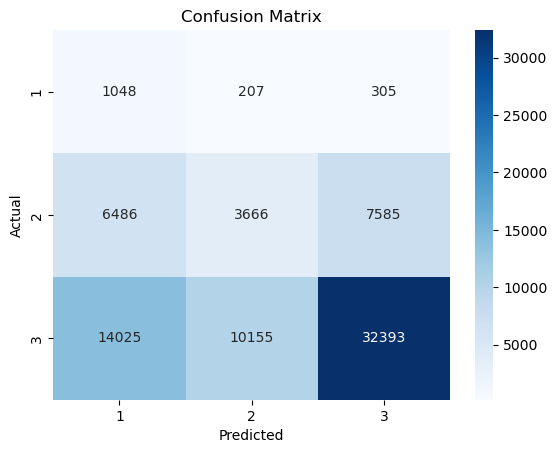

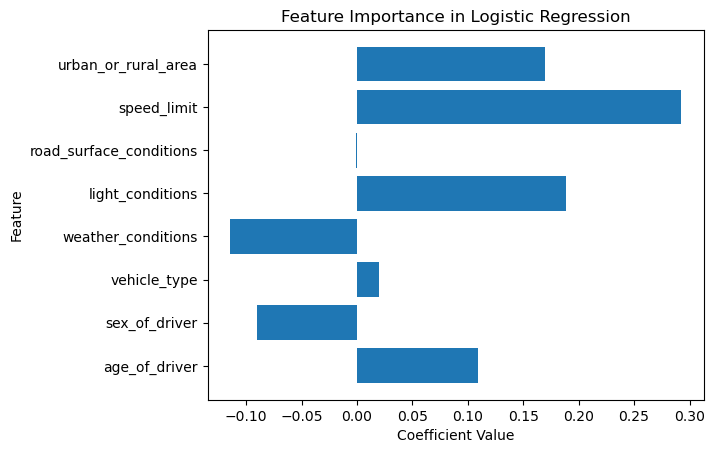

In [8]:
# 导入必要模块
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# 1. 数据预处理
# 标准化特征值
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. 使用 SMOTE 增强数据
print("Applying SMOTE to balance classes...")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)
print(f"Resampled dataset shape: {X_resampled.shape}")

# 3. 训练逻辑回归模型
print("Training Logistic Regression model...")
log_model = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced')
log_model.fit(X_resampled, y_resampled)

# 4. 预测和评估模型
print("Evaluating model...")
y_pred = log_model.predict(X_test_scaled)

# 输出混淆矩阵
print("Confusion Matrix after SMOTE:")
print(confusion_matrix(y_test, y_pred))

# 输出分类报告
print("\nClassification Report after SMOTE:")
print(classification_report(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt

# 绘制混淆矩阵
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 绘制特征重要性
importance = log_model.coef_[0]
plt.barh(X_train.columns, importance)
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

Confusion Matrix with Random Forest:
[[  719   389   452]
 [ 1306  7846  8585]
 [ 3105 13458 40010]]

Classification Report with Random Forest:
              precision    recall  f1-score   support

           1       0.14      0.46      0.21      1560
           2       0.36      0.44      0.40     17737
           3       0.82      0.71      0.76     56573

    accuracy                           0.64     75870
   macro avg       0.44      0.54      0.46     75870
weighted avg       0.70      0.64      0.66     75870



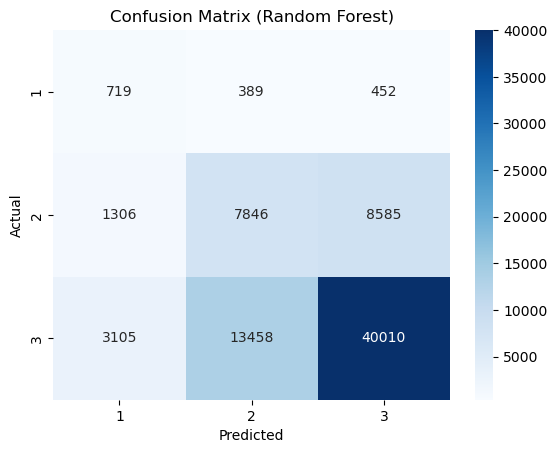

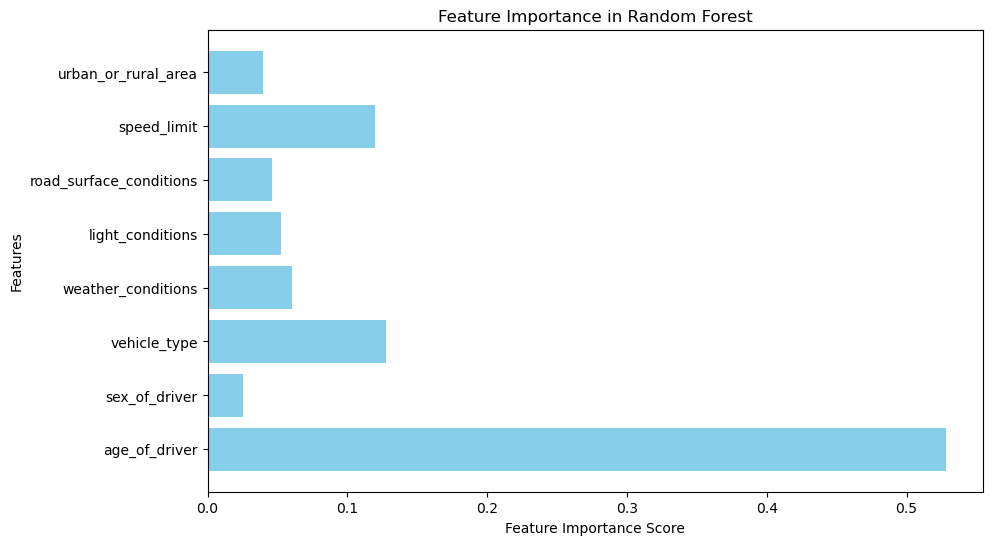

In [12]:
from sklearn.ensemble import RandomForestClassifier

# 使用随机森林分类器
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_resampled, y_resampled)

# 预测并评估
y_pred_rf = rf_model.predict(X_test_scaled)
print("Confusion Matrix with Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report with Random Forest:")
print(classification_report(y_test, y_pred_rf))

import seaborn as sns
import matplotlib.pyplot as plt

# 绘制混淆矩阵
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# 提取特征重要性
feature_importances = rf_model.feature_importances_

# 创建条形图
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances, color='skyblue')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.show()